# Frequency Analysis

### Import Data and packages

In [15]:
# Add the parent directory to sys.path
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

# Import packages
import os, sys, time, logging, csv
import pandas as pd
from multiprocessing import cpu_count
from dotenv import load_dotenv
from utils.preprocessing import TokenizerMP, run_logger, error_logger
from utils.gcp import load_data_from_gcs, upload_data_to_gcs, append_row_to_csv 

# Load environment variables
load_dotenv()

# Google Cloud Authentication
project_root = os.path.dirname(os.getcwd())
service_account = os.path.join(project_root, 'setup', os.getenv("GCP_SERVICE_ACCOUNT"))
from google.auth import credentials
from google.cloud import storage
client = storage.Client.from_service_account_json(service_account)
bucket_name = os.getenv("GCP_BUCKET_NAME")
file_name = "data/processed/20241115-154548__data.csv"

df = load_data_from_gcs(bucket_name, file_name, client)
df.head()

,source,text,label,id,tokens
0,toxic_comment,"(UTC)\n\nOn a similar note, do we have a sourc...",0,8f9e64acdea84d5e975fac1d0eaffa94,"['similar', 'note', 'source', 'spine', 'up', '..."
1,toxic_comment,You still don't seem to get the point I'm tryi...,0,1c15a627877d4af1a0769139d2cbdd2d,"['still', 'do', 'not', 'seem', 'get', 'point',..."
2,toxic_comment,Edward Hunt \n\nI see you have deleted this ar...,0,b481a95d6b084734a14af36063cf1e2f,"['edward', 'hunt', 'see', 'delete', 'article',..."
3,toxic_comment,. Chinamanjoe has been spreading lies through ...,0,d27ce573495b4cf0b83e3c62a8b23236,"['<UNK>', 'spread', 'lie', '<UNK>']"
4,toxic_comment,It's just nasty. If you open up any other norm...,2,e176e6b6d3544049a8c99179e1b57a1a,"['nasty', 'open', 'normal', 'encyclopedia', 'w..."


## Word Frequency Analysis

In [48]:
# Max/Mintokens length
max_token_length = 0
min_token_length = 0

for row in df.itertuples():
    if row.Index == 0:
        max_tokens = len(row.tokens)
        min_tokens = len(row.tokens)
    else:
        if len(row.tokens) > max_tokens:
            max_tokens = len(row.tokens)
        if len(row.tokens) < min_tokens:
            min_tokens = len(row.tokens)
            
            
            
# Mean, median and quantiles of tokens length
df['tokens_length'] = df['tokens'].apply(lambda x: len(x))
mean_length = df['tokens_length'].mean()
quantiles_length = df['tokens_length'].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])


# Unique tokens per sample
df["unique_tokens"] = df['tokens'].apply(lambda x: len(set(x)))
mean_unique_tokens = df['unique_tokens'].mean()
quantiles_unique_tokens = df['unique_tokens'].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

# Vocabulary analysis
vocab_size = len(set([token for token in df['tokens'] for token in token]))

# Top most frequent tokens
token_count = {}
for row in df.tokens :
	for token in row :
		if token not in list(token_count.keys()):
			token_count[token] = 1
		else:
			token_count[token] += 1
token_count = dict(sorted(token_count.items(), key=lambda item: item[1], reverse=True))
top_tokens = dict(list(token_count.items())[:20])


            

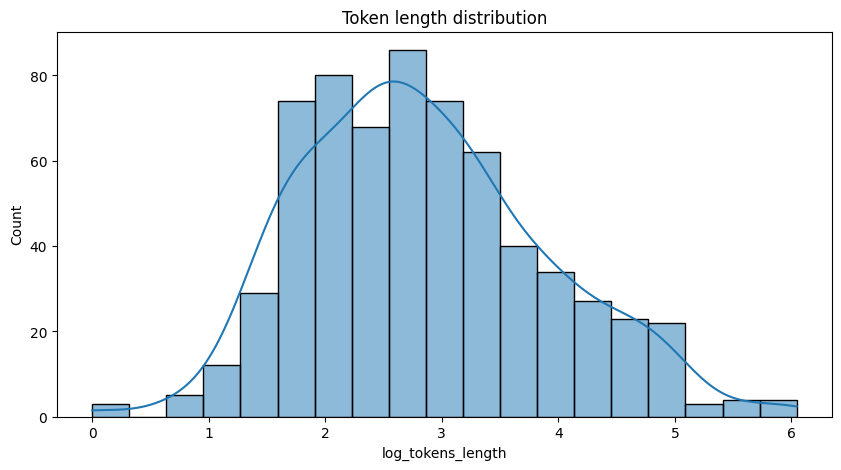

In [56]:
# Token length distribution and outlier detection
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Apply log transformation
df['log_tokens_length'] = df['tokens_length'].apply(lambda x: np.log(x+1))

plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(df['log_tokens_length'], kde=True)
plt.title("Token length distribution")
plt.show();

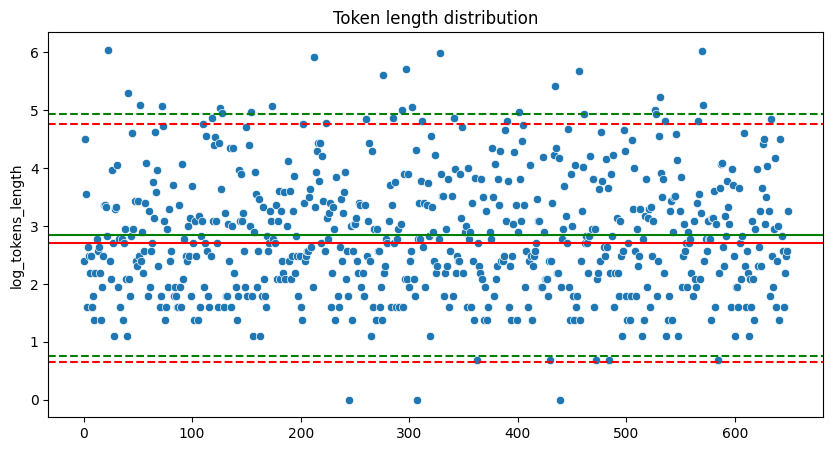

In [ ]:
# Token length distribution and outlier detection
# Scatter plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.scatterplot(x=list(df.index), y='log_tokens_length', data=df, ax=ax)
plt.title("Token length distribution")

# Outlier detection
mean = df['log_tokens_length'].mean()
median = df['log_tokens_length'].median()
std = df['log_tokens_length'].std()
mad = np.median(np.abs(df['log_tokens_length'] - median))

upper_bound = median + 2*(1.48*mad), mean + 2*std
lower_bound = median - 2*(1.48*mad), mean - 2*std

ax.axhline(upper_bound[0], color='r', linestyle='--')
ax.axhline(lower_bound[0], color='r', linestyle='--')
ax.axhline(upper_bound[1], color='g', linestyle='--')
ax.axhline(lower_bound[1], color='g', linestyle='--')
ax.axhline(mean, color='g', linestyle='-')
ax.axhline(median, color='r', linestyle='-')

plt.show();

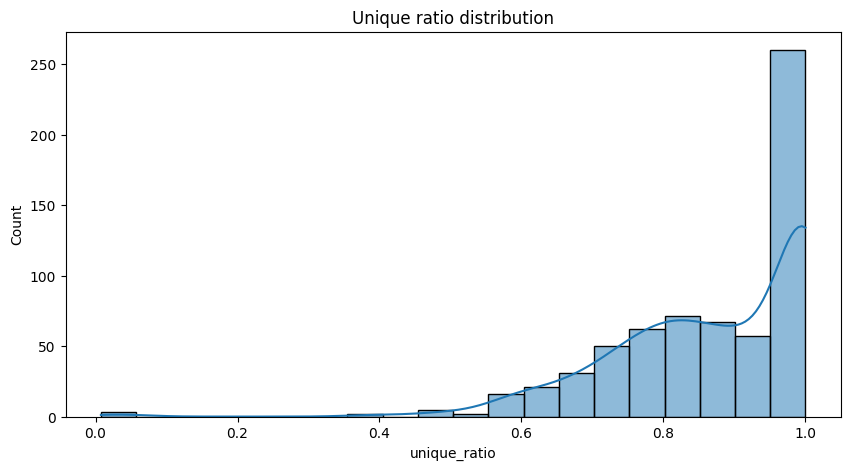

In [73]:
# Explore unique/length of tokens
df["unique_ratio"] = df['unique_tokens'] / df['tokens_length']

# Apply log transformation
epsilon = 1e-6
#df['log_unique_ratio'] = df['unique_ratio']


# Unique ratio distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(df['unique_ratio'], kde=True, ax=ax)
plt.title("Unique ratio distribution")
plt.show();


,source,text,label,id,tokens,tokens_length,unique_tokens,log_tokens_length,unique_ration,unique_ratio,log_unique_ratio
328,toxic_comment,I am going to kill you. I am going to murder y...,2,4a260462693c460c806a5d1a68a2c954,"[go, kill, go, murder, go, kill, go, murder, g...",399,3,5.991465,0.007519,0.007519,-4.890216
376,toxic_comment,ABF IS A FUCKINGABF IS A FUCKINGABF IS A FUCKI...,2,0d4c7efb2b6f403d925de1d9c7e39fbf,"[abe, <UNK>, <UNK>, <UNK>, <UNK>, <UNK>, <UNK>...",76,3,4.343805,0.039474,0.039474,-3.232096
467,toxic_comment,You're gay you're gay you're gay you're gay yo...,2,95d2e713b6814066a484a897c632104a,"[you, be, gay, you, be, gay, you, be, gay, you...",66,3,4.204693,0.045455,0.045455,-3.091020
527,toxic_comment,"""\n\n Please stop. If you continue to violate ...",0,122c26ca4cab429a85890f0cfbfffbcd,"[please, stop, continue, violate, <UNK>, origi...",139,55,4.941642,0.395683,0.395683,-0.927138
532,toxic_comment,"Andorra and Belize \n\nOk, here it goes:\n\nAn...",0,5ddfb5b656e14d0196d428b5a95a26a2,"[andorra, beside, ok, go, andorra, number, spa...",49,19,3.912023,0.387755,0.387755,-0.947379
